# Cleveland Dot plot for capacity and energy representation

for the French power system

PH, Oct 2019


Some references, apart from Cleveland book:

* “Cleveland (Dot Plot) Rocks! (with Tableau)”
https://spencerbaucke.com/2019/09/12/cleveland-dot-plot-rocks/

* UC Business Analytics R Programming Guide, “Cleveland Dot Plots” page
http://uc-r.github.io/cleveland-dot-plots

* https://www.jstor.org/stable/2288400
Graphical Perception: Theory, Experimentation, and Application to the Development of Graphical Methods
William S. Cleveland and Robert McGill
Journal of the American Statistical Association
Vol. 79, No. 387 (Sep., 1984), pp. 531-554 

In [2]:
import numpy as np
from numpy import log2, nan

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
%matplotlib inline

Read eCO2mix data (adapted from [RTE_explore_concat.ipynb](RTE_explore_concat.ipynb) Notebook)

In [3]:
columns_FR = [
    'Consommation',
    'Fioul', 'Charbon', 'Gaz', 'Nucléaire',
    'Eolien', 'Solaire',
    'Hydraulique', 'Pompage', 'Bioénergies',
    'Ech. physiques',
]

Translation of column names

In [7]:
columns = [
    'Load',
    'Oil', 'Coal', 'Gas', 'Nuclear',
    'Wind', 'Solar',
    'Hydro', 'Pump', 'Bio',
    'Exchanges',
]

In [8]:
def read_eCO2mix(fname, columns):
    """read eCO2mix data file. keep only `columns`"""
    df = pd.read_csv(fname, compression='xz', encoding='windows-1252',
                 sep='\t', skipfooter=2,engine='python',
                 index_col=False, parse_dates={'date':[2,3]})
    # keep only data at 30 min step
    df = df.iloc[::2,:]
    # set date as the index
    df.set_index('date', verify_integrity=True, inplace=True)
    df.index.name = ''
    # select columns
    return df.loc[:, columns]

Read only the main columns (not the detailed ones). Year 2017 as an example

In [9]:
df = read_eCO2mix('data/eCO2mix_RTE_Annuel-Definitif_2017.xls.xz', columns_FR)
# translate names:
df = df.rename(dict(zip(columns_FR, columns)), axis=1)

df.tail(3)

,Load,Oil,Coal,Gas,Nuclear,Wind,Solar,Hydro,Pump,Bio,Exchanges
,,,,,,,,,,,
2017-12-31 22:30:00,57239.0,164.0,37.0,2447.0,42271.0,10698.0,-1.0,6845.0,-1937.0,1171.0,-4456.0
2017-12-31 23:00:00,60642.0,164.0,37.0,2450.0,42718.0,10712.0,-1.0,8353.0,-1186.0,1161.0,-3766.0
2017-12-31 23:30:00,60479.0,165.0,37.0,2464.0,42064.0,10720.0,-1.0,7712.0,-1052.0,1163.0,-2793.0


### Post processing RTE data

Notes:
* Pompage is always negative
* 'Ech. physiques' is negative and positive

In [12]:
df.Pump.min(), df.Pump.max()

(-3595.0, -3.0)

In [13]:
df.Exchanges.min(), df.Exchanges.max()

(-17230.0, 10011.0)

For physical exchanges: split into two positive variables: Import and Export

In [14]:
pos = lambda x:  x if x >= 0 else 0
neg = lambda x: -x if x  < 0 else 0

In [15]:
df['Import'] = df['Exchanges'].map(pos)
df['Export'] = df['Exchanges'].map(neg)

In [16]:
del df['Exchanges']

For pumped hydro: flip the sign

In [17]:
df.Pump *= -1

### Residual negative values

negative values are probably the self-consumption of Coal and Solar

In [18]:
(df < 0).sum()

Load          0
Oil           0
Coal       1342
Gas           0
Nuclear       0
Wind          0
Solar      8279
Hydro         0
Pump          0
Bio           0
Import        0
Export        0
dtype: int64

In [19]:
df.Solar.describe()

count    17520.000000
mean      1026.673402
std       1452.396534
min         -2.000000
25%         -1.000000
50%         14.000000
75%       1917.000000
max       5528.000000
Name: Solar, dtype: float64

In [20]:
df.Coal.describe()

count    17520.00000
mean      1111.32911
std        839.51716
min        -67.00000
25%        362.00000
50%       1051.00000
75%       1831.00000
max       2951.00000
Name: Coal, dtype: float64

Conversion MW → GW

In [21]:
df /= 1000

### Aggregation

* mean power
* max power (i.e. a proxy for the capacity)

In [22]:
stats = pd.DataFrame(data={'avg': df.mean(), 'max': df.max()})

Sort: by mean or by max?

In [23]:
stats.sort_values('max', inplace=True)
stats

,avg,max
Bio,1.077469,1.364
Coal,1.111329,2.951
Pump,0.817413,3.595
Oil,0.397095,4.231
Solar,1.026673,5.528
Gas,4.513795,9.583
Import,0.415179,10.011
Wind,2.750865,11.249
Hydro,6.051790,14.954
Export,5.093133,17.230


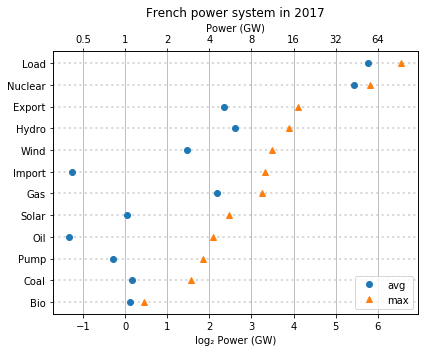

In [24]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

# twin ax with shared scale
# cf. @ImportanceOfBeingErnest at https://stackoverflow.com/questions/55907892/matplotlib-secondary-axis-with-values-mapped-from-primary-axis
ax2 = ax.twiny()
ax.get_shared_x_axes().join(ax, ax2)

markers = {
    'avg': 'o',
    'max': '^'}

for col in stats.columns:
    ax.plot(log2(stats[col]), stats.index, label=col,
            ls='', marker=markers[col])

ax.grid(axis='x', ls='-')
ax.grid(axis='y', ls=':', lw=2, alpha=0.5)
ax.set(
    xlabel='log₂ Power (GW)',
    title='French power system in 2017'
)

ax.legend(loc='lower right')

ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: f'{2**x:.4g}'))
ax2.set_xlabel('Power (GW)')

fig.tight_layout()
fig.savefig('Dot-plot capa energy.png', dpi=150)

## Automate for other years

### Stats for each available year

In [25]:
def power_stats(year):
    df = read_eCO2mix(f'data/eCO2mix_RTE_Annuel-Definitif_{year}.xls.xz', columns_FR)
    # translate names:
    df = df.rename(dict(zip(columns_FR, columns)), axis=1)

    # Sign flip for pumped hydro
    df.Pump *= -1
    
    # Split of imports and exports
    pos = lambda x:  x if x >= 0 else 0
    neg = lambda x: -x if x  < 0 else 0
    
    df['Import'] = df['Exchanges'].map(pos)
    df['Export'] = df['Exchanges'].map(neg)
    
    del df['Exchanges']
    
    stats = pd.DataFrame(data={'avg': df.mean(), 'max': df.max()})
    # MW → GW
    stats /= 1000
    return stats

In [26]:
stats_y = {y: power_stats(y) for y in range(2012, 2019)}

Concat the yearly stats (create a multi index)

In [27]:
stats_y = pd.concat(stats_y, axis=1)

Sort: by max of last year (2018)

In [28]:
stats_y.sort_values((2018,'max'), inplace=True)
stats_y

2012                2013               2014               2015  \
               avg      max        avg     max        avg     max        avg   
Bio       0.664442    0.799   0.707971   0.835   0.857310   1.049   0.903689   
Oil       0.517325    5.926   0.453910   3.914   0.272259   2.008   0.302985   
Coal      1.986089    5.436   2.251811   6.265   0.949289   4.532   0.982870   
Pump      0.763865    3.376   0.821367   3.637   0.912476   3.615   0.786741   
Solar     0.430648    2.489   0.519008   2.950   0.664259   3.615   0.831773   
Import    0.146497    9.289   0.087988   4.930   0.001561   1.939   0.001788   
Gas       2.850610    8.625   2.282787   8.329   1.627784   7.366   2.522096   
Wind      1.696575    6.198   1.816477   6.531   1.947372   7.379   2.408021   
Export    5.400491   13.594   5.694872  13.198   7.749328  13.878   7.374533   
Hydro     7.213284   16.380   8.521735  16.805   7.689527  16.615   6.680557   
Nuclear  46.055824   60.811  46.058161  59.107  47.432007  61.232  47.540451   
Load     55.396962  102.098  56.185530  92.629  52.779499  82.607  54.012878   

                      2016               2017               2018          
            max        avg     max        avg     max        avg     max  
Bio       1.161   0.991731   1.261   1.077469   1.364   1.089724   1.286  
Oil       3.430   0.196102   3.058   0.397095   4.231   0.234531   2.507  
Coal      3.580   0.831307   2.806   1.111329   2.951   0.656297   2.931  
Pump      3.603   0.768689   3.362   0.817413   3.595   0.844763   3.651  
Solar     4.371   0.940439   5.231   1.026673   5.528   1.208082   6.430  
Import    2.204   0.281877   8.468   0.415179  10.011   0.109121   9.574  
Gas       8.052   4.026467   9.504   4.513795   9.583   3.446567   9.700  
Wind      8.331   2.381363   8.647   2.750865  11.249   3.211288  12.287  
Export   16.163   5.092918  16.227   5.093133  17.230   7.383905  16.577  
Hydro    15.649   7.213065  16.253   6.051790  14.954   7.695196  17.434  
Nuclear  61.712  43.682177  59.461  43.251854  56.885  44.861127  58.640  
Load     91.934  54.681288  88.731  54.685462  94.236  54.283220  96.272

### Plot

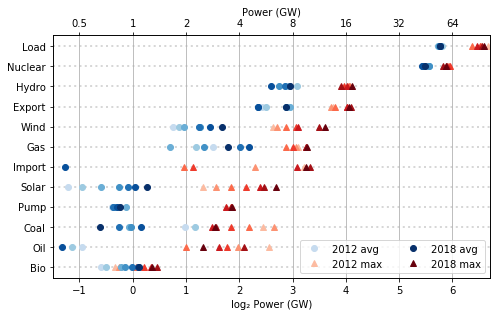

In [71]:
def dotplot_power_stats(stats_y, years):
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    
    # twin ax with shared scale
    # cf. @ImportanceOfBeingErnest at https://stackoverflow.com/questions/55907892/matplotlib-secondary-axis-with-values-mapped-from-primary-axis
    ax2 = ax.twiny()
    ax.get_shared_x_axes().join(ax, ax2)

    markers = {
        'avg': 'o',
        'max': '^'}
    
    for year in years:
        for s in ['avg', 'max']:
            col = (year, s)
            #if year == 2016: continue # keep only 2014 and 2018
            ym = min(years)
            yM = max(years)
            if yM>ym:
                a = (year - ym)/(yM-ym)
                a = 0.25 + a*0.75#(a-0.5)*0.7 + 0.5
            else:
                a = 0.7
            if s == 'avg':
                color = cm.Blues(a)
            elif s == 'max':
                color = cm.Reds(a)
            
            if year == ym or year == yM:
                label = f'{year} {s}'
            else:
                label = ''
            ax.plot(log2(stats_y[col]), stats_y.index, label=label,
                    ls='', marker=markers[s], color=color)

    ax.grid(axis='x', ls='-')
    ax.grid(axis='y', ls=':', lw=2, alpha=0.5)
    ax.set(
        xlabel='log₂ Power (GW)'
    )
    ax.set_xlim(-1.5, 6.7)
    ax.locator_params('x', nbins=10)
    
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: f'{2**x:.4g}'))
    ax2.set_xlabel('Power (GW)')
    
    ncol = 2 if yM > ym else 1
    ax.legend(loc='lower right', ncol=ncol)
    

    fig.tight_layout(rect=(0,0.1,1,1))
    years_txt = '20' + '-'.join(str(y)[2:] for y in years)
    fig.savefig(f'Dot-plot capa energy {years_txt}.png', dpi=300, bbox_inches='tight')

dotplot_power_stats(stats_y, range(2012, 2019))

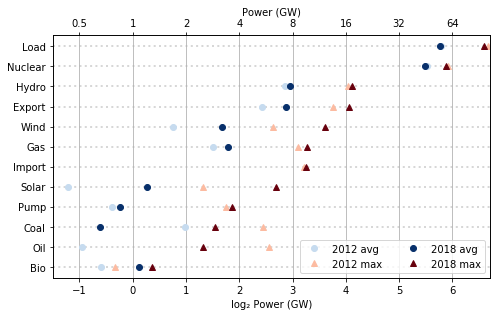

In [73]:
dotplot_power_stats(stats_y, [2012, 2018])

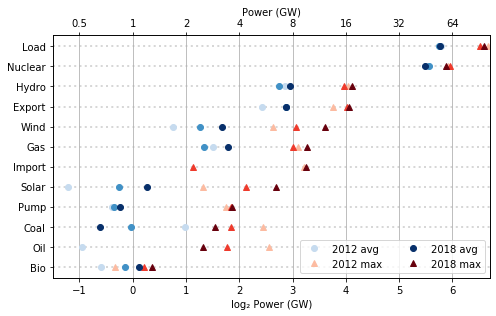

In [74]:
dotplot_power_stats(stats_y, [2012, 2015, 2018])

Generate the individual plot for each year

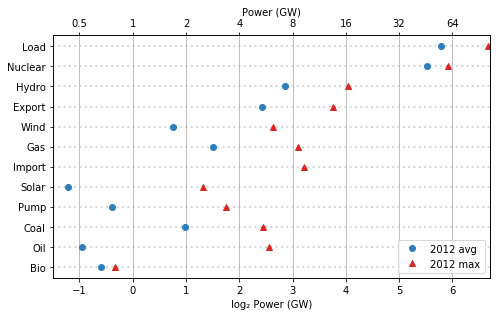

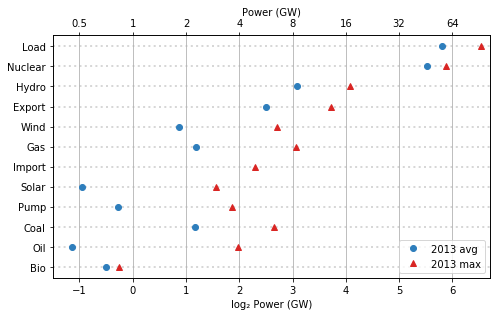

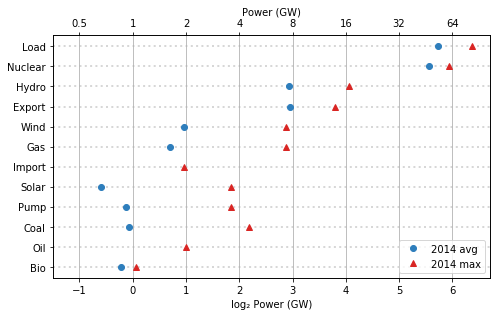

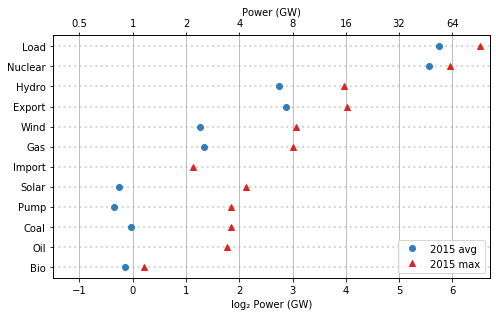

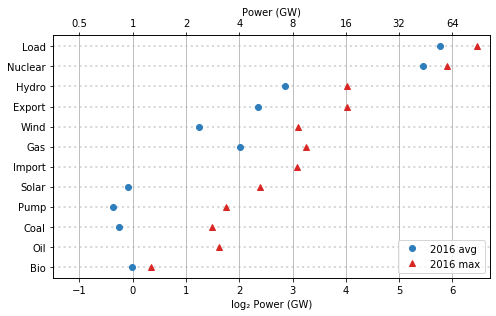

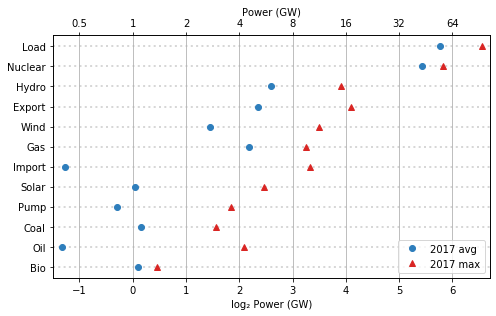

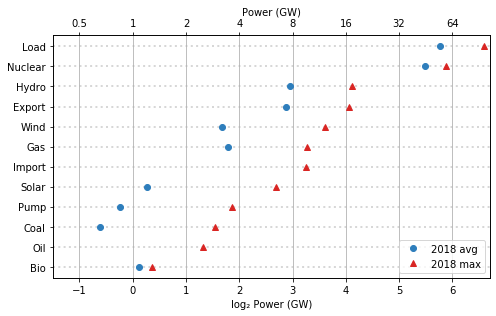

In [75]:
for year in range(2012, 2019):
    dotplot_power_stats(stats_y, [year])

## Plot with altair

In [34]:
import altair as alt

reshaping data to from wide to [long-form](https://altair-viz.github.io/user_guide/data.html#long-form-vs-wide-form-data) with `DataFrame.melt`:

In [56]:
stats_yl = stats_y.reset_index().melt('index', var_name=['year', 'stat'])
stats_yl.rename(columns={'index':'type'}, inplace=True)
# log2 transform
stats_yl['log2'] = np.log2(stats_yl.value)
stats_yl

,type,year,stat,value,log2
0,Bio,2012,avg,0.664442,-0.589785
1,Oil,2012,avg,0.517325,-0.950856
2,Coal,2012,avg,1.986089,0.989930
3,Pump,2012,avg,0.763865,-0.388610
4,Solar,2012,avg,0.430648,-1.215420
...,...,...,...,...,...
163,Wind,2018,max,12.287000,3.619061
164,Export,2018,max,16.577000,4.051111
165,Hydro,2018,max,17.434000,4.123832
166,Nuclear,2018,max,58.640000,5.873813


Year column, for selection

In [58]:
y = stats_yl.year

In [75]:
sorted_types = stats_y.index.values
sorted_types = list(sorted_types)
sorted_types.reverse()

### For a single year

TODO: 
* find a better way to customize the color and the shape without breaking the legend → DONE

In [104]:
alt.themes.get()()

{'config': {'view': {'width': 400, 'height': 300}, 'mark': {'tooltip': None}}}

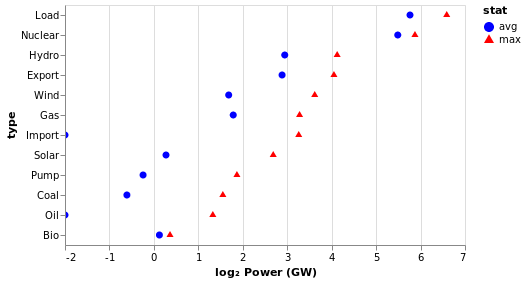

In [178]:
#shape_scale = alt.Scale(domain=['avg', 'max'], range=['circle', 'triangle'])

color_scale = alt.Scale(domain=['avg', 'max'], range=['blue', 'red'])

alt.Chart(stats_yl[y==2018]).mark_point(filled=True, size=50, opacity=1).encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
    color=alt.Color('stat',
        scale=color_scale
    ),
    shape=alt.Shape(
        'stat', 
        scale=shape_scale
    ),
    tooltip=['year', 'value']
).interactive()

### For all years

In [90]:
out = stats_yl.log2 < -1.5 # outliers

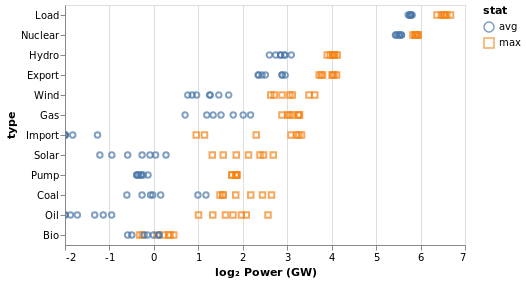

In [165]:
alt.Chart(stats_yl).mark_point().encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
    color='stat',
    shape='stat',
    tooltip=['year', 'value']
).interactive()

### All years - with interactive selection


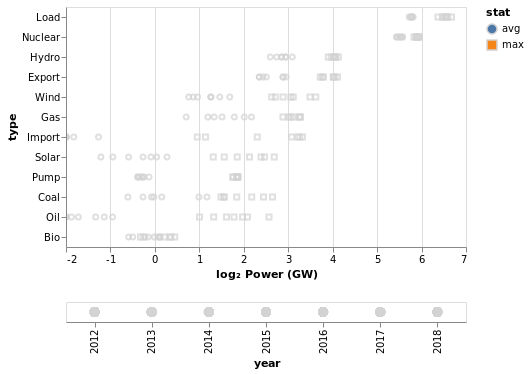

In [183]:
selector = alt.selection_single(
    fields=['year'],
    empty='none',
    on='mouseover',
    nearest=True
)

base = alt.Chart(stats_yl).properties(
    width=400,
).add_selection(selector)

# The Dot plot
values  = base.mark_point().encode(
    x=alt.X('log2', 
        scale = alt.Scale(
            domain=(-2,7),
            clamp=True # nice for interactive charts. otherwise, clip=True may be better
        ),
        axis=alt.Axis(title='log₂ Power (GW)')
    ),
    y=alt.Y('type', sort=sorted_types),
    shape=alt.Shape(
        'stat', 
        #scale=shape_scale
    ),
    # Make color, size, etc... interactive
    fill=alt.condition(selector,
                        'stat',
                        alt.value('lightgray')),
    stroke=alt.condition(selector,
                        'stat',
                        alt.value('lightgray')),
    fillOpacity=alt.condition(selector,
                        alt.value(1),
                        alt.value(0)),
    opacity=alt.condition(selector,
                        alt.value(1),
                        alt.value(0.7)),
    size=alt.condition(selector,
                       alt.value(50),
                       alt.value(25)),
    tooltip=['year', 'value']
).interactive()

# Year selector
years = base.mark_point(filled=True, size=100).encode(
    x='year:O',
    color=alt.condition(selector,
                        alt.value('green'),
                        alt.value('lightgray')),
)

chart = values & years
chart

In [170]:
chart.save('Dot-plot-interactive.html')
chart.save('Dot-plot-interactive.json')